(quickstart)=
# Quickstart: simple linear regression

We demonstrate here how to use BayesBay to tackle a simple linear regression problem: polynomial fitting. In the following, we utilise a third-degree polynomial, $y(x) = m_0 + m_1 x + m_2 x^2 + m_3 x^3$, to generate data points. Noise is then added to this data. Our objective is to retrieve the coefficients $m_0$, $m_1$, $m_2$, and $m_3$ from the observations.

For simplicity, we shall assume that the data noise is known (refer to this [tutorial](1_hierarchical) for a hierarchical example where the data noise is treated as unknown). We also assume that prior information about the bounds of the true coefficients is available. (Without this information, Bayesian sampling would be inappropriate for tackling this kind of toy problem.)

## Import libraries and define constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesbay as bb

In [2]:
# dimensions and true coefficients
N_DIMS = 4
M0, M1, M2, M3 = 20, -10, -3, 1

# data and noise
N_DATA = 15
DATA_X = np.linspace(-5, 10, N_DATA)
DATA_NOISE_STD = 20

## Synthetic data and data kernel

In matrix notation and without considering noise, our data set can be expressed as

$$\underbrace{\left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right)}_{\text{Data}} = \underbrace{\left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)}_{\text{Forward operator or data kernel}} \underbrace{\left(\begin{array}{c}m_0\\m_1\\m_2\\m_3\end{array}\right)}_{\text{Model}},$$

or $\mathbf{d} = \mathbf{G m}$.

The following code block defines the forward operator, which will be utilised throughout the Bayesian sampling and in the generation of noisy data.

In [3]:
fwd_operator = np.vander(DATA_X, N_DIMS, True)
y = fwd_operator @ [M0, M1, M2, M3]
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

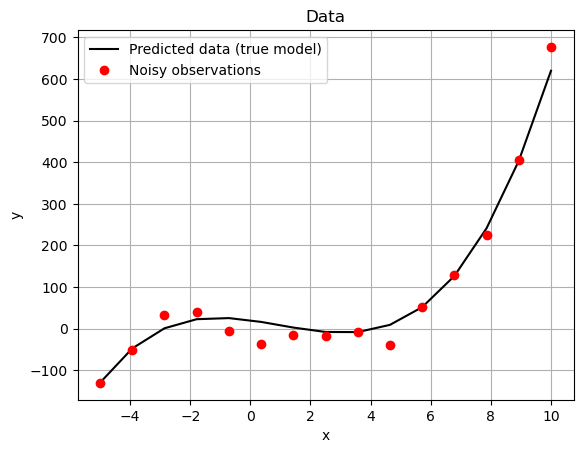

In [4]:
fig, ax = plt.subplots()
ax.set_title('Data')
ax.plot(DATA_X, y, 'k', label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

To solve the inverse problem inherent in inferring the coefficients $\mathbf{m}$ from the observations, we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the unknowns parameters and their prior probability
* A *forward function*, enabling the prediction of data points $\mathbf{d}_{pred}$ from the model $\mathbf{m}$
* What we refer to as a [Target](../api/generated/bayesbay.Target), that is, a Python object designed to store all information about a given data set

### Prior probability

As anticipated, we assume that prior information on the bounds of the sought parameters is available. For example, we may known that 

* $-100\leq m_0 \leq100$ 
* $-50\leq m_1 \leq50$
* $-20\leq m_2 \leq20$
* $-10\leq m_3 \leq10$. 

This information naturally leads to the use of uniform prior probabilities for each unknown (different options for the prior of a free parameter are available through the module [bayesbay.parameters](../api/api_standard_parameters)).

In [5]:
m0 = bb.parameters.UniformParameter("m0", -100, 100, 5)
m1 = bb.parameters.UniformParameter("m1", -50, 50, 5)
m2 = bb.parameters.UniformParameter("m2", -20, 20, 3)
m3 = bb.parameters.UniformParameter("m3", -10, 10, 2)

### Parameter space and parameterization

The free parameters we have defined, regardless of their prior probability, should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). Mathematically, ParameterSpace can be thought of as a vector space defined by a set of standard basis vectors. Each point (vector) within this space corresponds to a free parameter in the inference problem, and the position of each point defines the model parameters $\mathbf{m}_i \in \mathbb{R}^n$, where $n$ denotes the dimensionality of ParameterSpace and $\mathbf{m}_i \subseteq \mathbf{m}$. Importantly, in our implementation $n$ can be treated as a variable to enable trans-dimensional Bayesian sampling.

From a computer programming perspective, ParameterSpace could be seen as a specialized container that not only groups a number of free parameters but also determines their dimensionality. For instance, in this tutorial's case, ParameterSpace will contain four distinct free parameters (namely, the unknown coefficients $m_0$, $m_1$, $m_2$, and $m_3$), and since these are scalars, its dimensionality will remain fixed and equal to one throughout the inversion. Finally, under the hood ParameterSpace also defines the perturbation functions used to propose new model parameters from the given ones (for more information, see the module [bayesbridge.perturbations](../api/api_standard_perturbations)).

Having defined one or more instances of ParameterSpace, these should be used to define a [Parameterization](../api/generated/bayesbay.parameterization.Parameterization). Parameterization is a relatively simple object compared to ParameterSpace, and its main purpose is to aggregate all model parameters (from all specified instances of ParameterSpace) to define $\mathbf{m} = \lbrace \mathbf{m}_1, \mathbf{m}_2, \mathbf{m}_3, \dots \rbrace$.

In [6]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=1, 
    parameters=[m0, m1, m2, m3], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### Defining the forward problem

Another fundamental ingredient in BayesBay is the definition of the forward function. This function is required to return the predicted data in the form of a numpy array, which is then used to calculate the likelihood $p({\bf d}_{obs} \mid {\bf m})$. As illustrated in the code block below, the forward function should be programmed to take in a [bayesbay.State](../api/generated/bayesbay.State), from which all model parameters can be accessed.

In [7]:
def fwd_function(state: bb.State) -> np.ndarray:
    m = [state["my_param_space"][f"m{i}"] for i in range(N_DIMS)]
    return np.squeeze(fwd_operator @ m)

### Defining the observed data

In BayesBay, the observed data should be used to define what we call a data [Target](../api/api_standard_target), which allows for treating the data noise as an unknown. In this case, we use the true standard deviation of the data noise to define the inverse of the data covariance matrix.

In [8]:
target = bb.Target(
    name="my_data", 
    dobs=y_noisy, 
    covariance_mat_inv=1/DATA_NOISE_STD**2)

## Run the Bayesian sampling

We can now use all defined variables to solve the inference problem. The code below is self-explanatory. Just notice the arguments ``targets`` and ``fwd_functions`` of [bayesbay.BayesianInversion](../api/generated/bayesbay.BayesianInversion): rather than one data target and forward function, as defined earlier, these can accept of list of targets and a list of functions. This makes it straigthforward to carry joint inversions of multiple data sets associated with potentially different forward functions.

In [9]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=fwd_function, 
    n_chains=3, 
    n_cpus=3, 
)
inversion.run(
    sampler=None, 
    n_iterations=100_000, 
    burnin_iterations=10_000, 
    save_every=500, 
    verbose=False, 
)

## Retrieve the results and plot

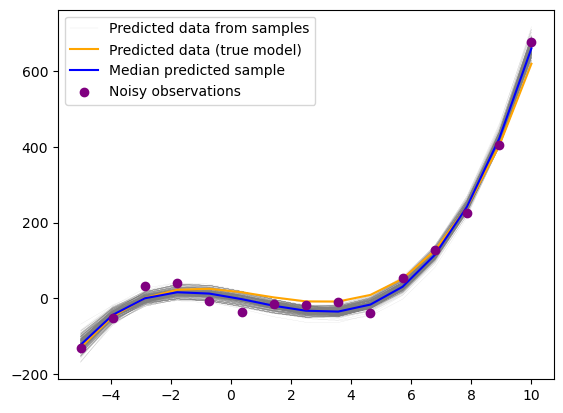

In [10]:
results = inversion.get_results()
coefficients_samples = np.squeeze(np.array([results[f"m{i}"] for i in range(N_DIMS)]))

fig, ax = plt.subplots()
all_y_pred = np.zeros((coefficients_samples.shape[1], len(y)))
for i, coefficients in enumerate(coefficients_samples.T):
    y_pred = fwd_operator @ coefficients
    all_y_pred[i,:] = y_pred
    if i == 0:
        ax.plot(DATA_X, y_pred, c='gray', lw=0.05, label="Predicted data from samples")
    else:
        ax.plot(DATA_X, y_pred, c='gray', lw=0.05)
ax.plot(DATA_X, y, c='orange', label='Predicted data (true model)')
ax.plot(DATA_X, np.median(all_y_pred, axis=0), c="blue", label='Median predicted sample')
ax.scatter(DATA_X, y_noisy, c='purple', label='Noisy observations', zorder=3)
ax.legend()
plt.show()